### Importación de librerías

In [1]:
import librosa
import librosa.display
import tqdm
import os
import scipy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

import dtale as dt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

----

### Lectura de los datasets

In [2]:
urbansound8k_path = "../../data/raw/UrbanSound8K/"

# Primer dataset - Carpeta con los audios
urbansound8k_audio_path = "audio/"

# Segundo dataset - Archivo CSV con metadatos de los audios
urbansound8k_metadata_path_file = "metadata/UrbanSound8K.csv"

In [3]:
metadata_urbansound8k_df = pd.read_csv( urbansound8k_path + urbansound8k_metadata_path_file, sep=",")
display(metadata_urbansound8k_df.head(1))

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark


----

### Obtención de nuevos metadatos

In [4]:
audio_duracion_list = []
audio_tasa_muestreo_list = []
audio_cantidad_canales_list = []
audio_rango_dinamico_list = []
audio_tasa_cruce_cero_list = []
audio_entropia_espectograma_list = [] 
audio_path_list = []

muestras_duracion_sumatoria = 0
for index, row in metadata_urbansound8k_df.iterrows():
    path_total_file = f"{urbansound8k_path}/audio/fold{row['fold']}/{row['slice_file_name']}"
    serie_tiempo, tasa_muestreo_hz = librosa.load(path_total_file, sr=44100, mono=True)

    # Calcular la duración (en segundos) de una serie temporal de audio
    duracion_segundos = librosa.get_duration(y=serie_tiempo, sr=tasa_muestreo_hz)

    # Cantidad de canales
    cantidad_canales = len(serie_tiempo.shape)

    # Rango Dinámico: Variabilidad en la intensidad del sonido
    rango_dinamico = np.max(serie_tiempo) - np.min(serie_tiempo)   

    # Tasa de Cruces por Cero: mide cuántas veces la señal cruza la línea de cero en un período de tiempo
    zero_crossings = librosa.zero_crossings(serie_tiempo, pad=False)    
    tasa_cruce_cero = np.sum(zero_crossings)

    # Entropía del espectrograma: complejidad de los sonidos
    spec = np.abs(librosa.stft(serie_tiempo))**2
    entropia_espectograma = scipy.stats.entropy(spec.flatten())
    
    # Promedio del Centroide Espectral: Medida de la "frecuencia central" de una señal
    spectral_centroids = librosa.feature.spectral_centroid(y=serie_tiempo, sr=tasa_muestreo_hz)[0]    
    avg_centroide_espectral = np.mean(spectral_centroids)   

    audio_path_list.append(path_total_file)
    audio_duracion_list.append(duracion_segundos)
    audio_tasa_muestreo_list.append(tasa_muestreo_hz)
    audio_cantidad_canales_list.append(cantidad_canales)
    audio_rango_dinamico_list.append(rango_dinamico)
    audio_tasa_cruce_cero_list.append(tasa_cruce_cero)
    audio_entropia_espectograma_list.append(entropia_espectograma)

metadata_urbansound8k_df['path'] = audio_path_list
metadata_urbansound8k_df['duracion'] = audio_duracion_list
metadata_urbansound8k_df['tasa_muestreo'] = audio_tasa_muestreo_list
metadata_urbansound8k_df['cantidad_canales'] = audio_cantidad_canales_list
metadata_urbansound8k_df['rango_dinamico'] = audio_rango_dinamico_list
metadata_urbansound8k_df['tasa_cruce_cero'] = audio_tasa_cruce_cero_list
metadata_urbansound8k_df['entropia_espectograma'] = audio_entropia_espectograma_list


###  Guardamos nuevos metadatos

In [5]:
metadata_urbansound8k_df.to_csv("../../data/processed/cd02_nuevos_metadatos_v2.csv", sep=';', index=False)

In [8]:
dataset_urbansound8k_df = pd.read_csv("../../data/processed/cd02_nuevos_metadatos_v2.csv", sep=";")

In [9]:
def reporte_descripcion_dataset(df):
    columnas = df.columns
    print("Columnas del dataset:\n")
    for col in columnas:
        print(col)
    print(f"\nCantidad de filas: {df.shape[0]}")

reporte_descripcion_dataset(dataset_urbansound8k_df)

Columnas del dataset:

slice_file_name
fsID
start
end
salience
fold
classID
class
path
duracion
tasa_muestreo
cantidad_canales
rango_dinamico
tasa_cruce_cero
entropia_espectograma

Cantidad de filas: 8732


### Exploracion por variable Clase

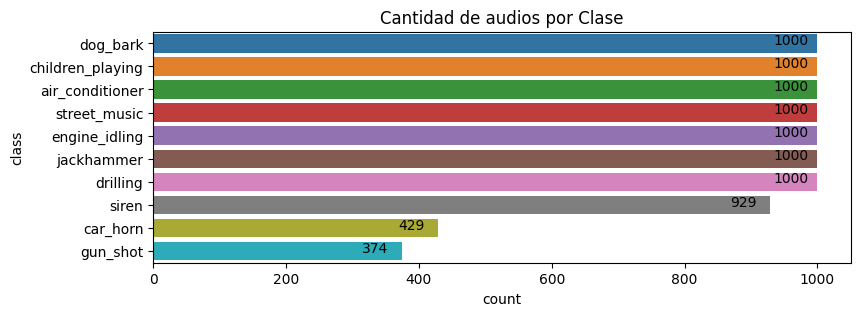

In [11]:
# Cantidad de audios por Clase
plt.figure(figsize=(9,3))
ax = sns.countplot(y=dataset_urbansound8k_df['class'], 
              order=dataset_urbansound8k_df['class'].value_counts().index,
              palette =sns.color_palette(n_colors=10))

for p in ax.patches:
    width = p.get_width()  # Anchura de la barra
    plt.text(width - 40,  # Posición en el eje x (ligeramente desplazado a la derecha)
             p.get_y() + p.get_height() / 3,  # Posición en el eje y
             int(width),  # El valor de la cantidad
             ha='center', va='center')  # Alineación del texto

plt.title("Cantidad de audios por Clase")
plt.show()

2024-09-11 19:05:49,833 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-11 19:05:49,839 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


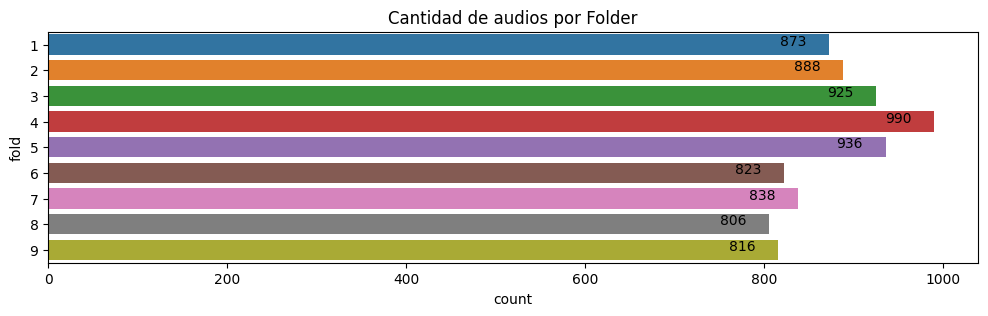

In [12]:
# Cantidad de audios por Folder
plt.figure(figsize=(12,3))
ax = sns.countplot(y=dataset_urbansound8k_df['fold'], 
              order=[num for num in range(1,10)],
              palette =sns.color_palette(n_colors=10))

for p in ax.patches:
    width = p.get_width()  # Anchura de la barra
    plt.text(width - 40,  # Posición en el eje x (ligeramente desplazado a la derecha)
             p.get_y() + p.get_height() / 3,  # Posición en el eje y
             int(width),  # El valor de la cantidad
             ha='center', va='center')  # Alineación del texto

plt.title("Cantidad de audios por Folder")
plt.show()

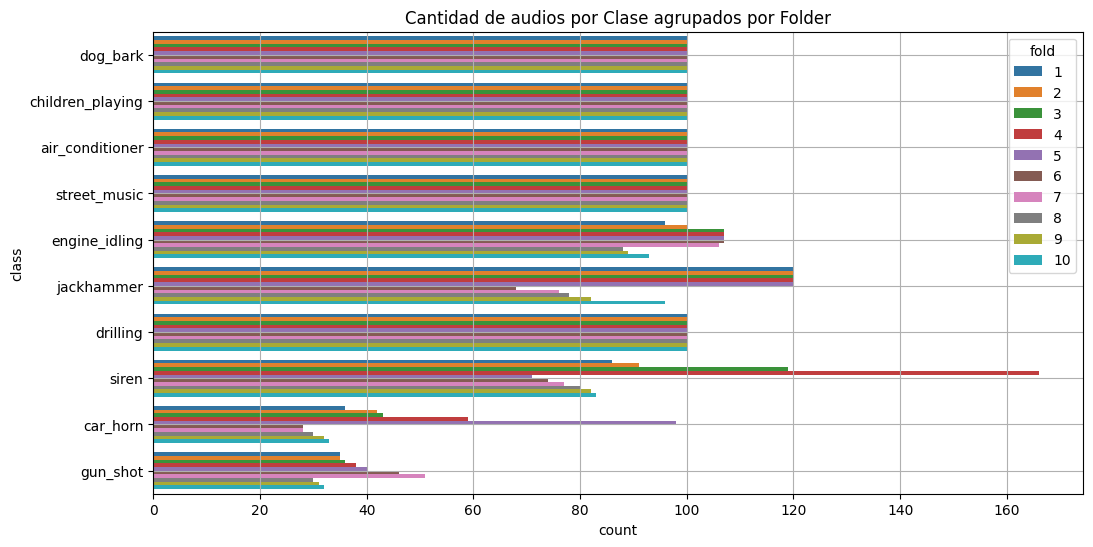

In [13]:
# Cantidad de audios por Clase agrupados por Folder
plt.figure(figsize=(12,6))
ax = sns.countplot(y=dataset_urbansound8k_df['class'], 
              order=dataset_urbansound8k_df['class'].value_counts().index, 
              hue=dataset_urbansound8k_df['fold'],
              palette =sns.color_palette(n_colors=10)) 

plt.title("Cantidad de audios por Clase agrupados por Folder")
plt.grid()
plt.show()


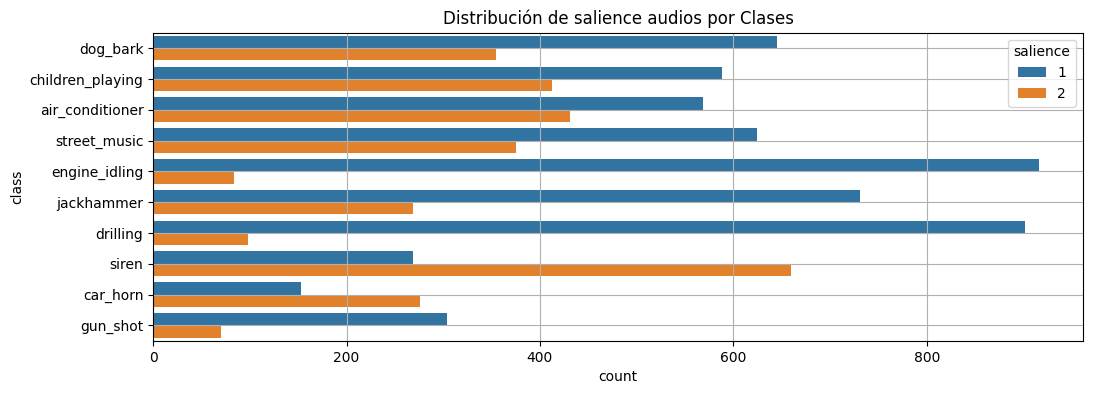

In [14]:
# Distribución de salience audios por Clases
plt.figure(figsize=(12,4))
ax = sns.countplot(y=dataset_urbansound8k_df['class'], 
              order=dataset_urbansound8k_df['class'].value_counts().index, 
              hue=dataset_urbansound8k_df['salience'],
              palette =sns.color_palette(n_colors=10)) 
plt.title("Distribución de salience audios por Clases")
plt.grid()
plt.show()

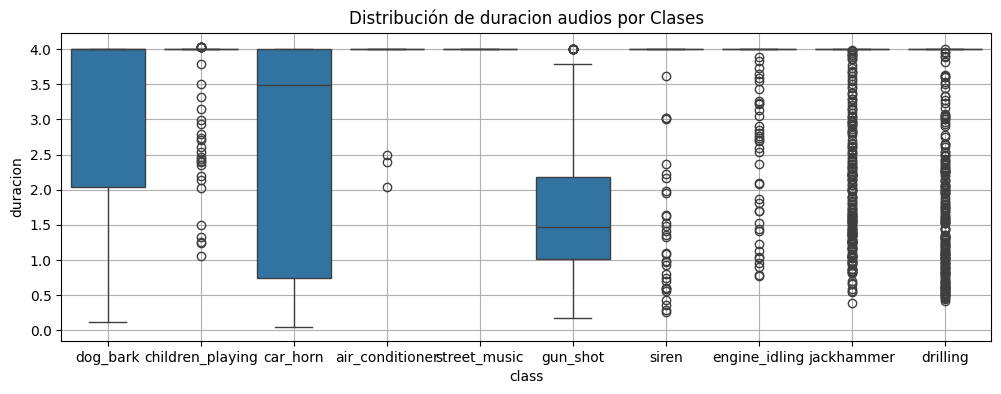

In [15]:
# Distribución de duracion audios por Clases
plt.figure(figsize=(12,4))
ax = sns.boxplot(y=dataset_urbansound8k_df['duracion'], x=dataset_urbansound8k_df['class']) 
plt.title("Distribución de duracion audios por Clases")
plt.grid()
plt.show()

In [16]:
# Distribución de duracion audios
result = dataset_urbansound8k_df.groupby(['duracion']).size().reset_index(name='count')
result = result.sort_values(by=['count'], ascending=[False])

display(result)

     duracion  count
967  4.000000   7325
510  1.440000     10
471  1.330000     10
367  1.090000      9
334  1.020000      7
..        ...    ...
458  1.305351      1
459  1.307279      1
132  0.520000      1
461  1.310023      1
485  1.367823      1

[970 rows x 2 columns]


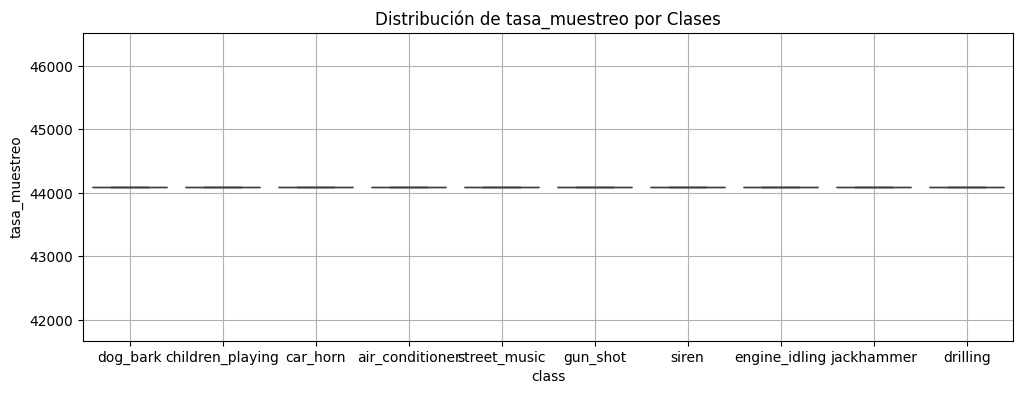

In [17]:
# Distribución de tasa_muestreo por Clases
plt.figure(figsize=(12,4))
ax = sns.boxplot(y=dataset_urbansound8k_df['tasa_muestreo'], x=dataset_urbansound8k_df['class']) 
plt.title("Distribución de tasa_muestreo por Clases")
plt.grid()
plt.show()

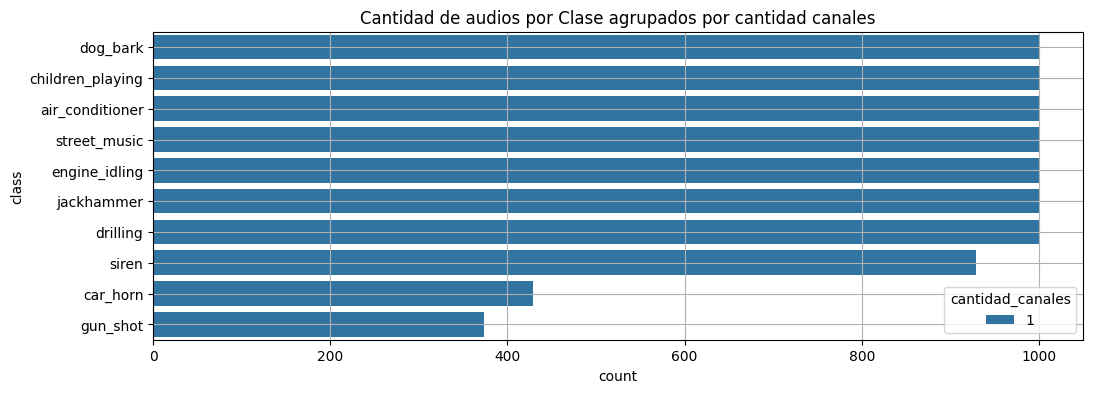

In [18]:
# Cantidad de audios por Clase agrupados por cantidad canales
plt.figure(figsize=(12,4))
ax = sns.countplot(y=dataset_urbansound8k_df['class'], 
              order=dataset_urbansound8k_df['class'].value_counts().index, 
              hue=dataset_urbansound8k_df['cantidad_canales'],
              palette =sns.color_palette(n_colors=10)) 

plt.title("Cantidad de audios por Clase agrupados por cantidad canales")
plt.grid()
plt.show()


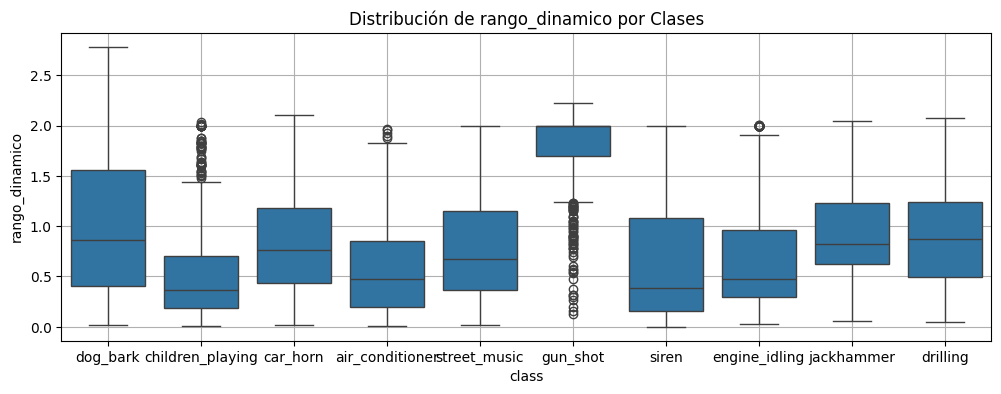

In [19]:
# Distribución de rango_dinamico por Clases
plt.figure(figsize=(12,4))
ax = sns.boxplot(y=dataset_urbansound8k_df['rango_dinamico'], x=dataset_urbansound8k_df['class']) 
plt.title("Distribución de rango_dinamico por Clases")
plt.grid()
plt.show()

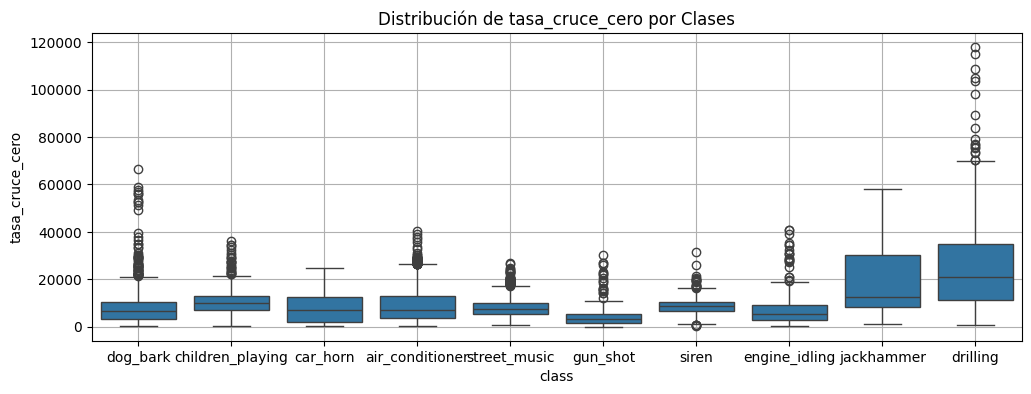

In [20]:
# Distribución de tasa_cruce_cero por Clases
plt.figure(figsize=(12,4))
ax = sns.boxplot(y=dataset_urbansound8k_df['tasa_cruce_cero'], x=dataset_urbansound8k_df['class']) 
plt.title("Distribución de tasa_cruce_cero por Clases")
plt.grid()
plt.show()

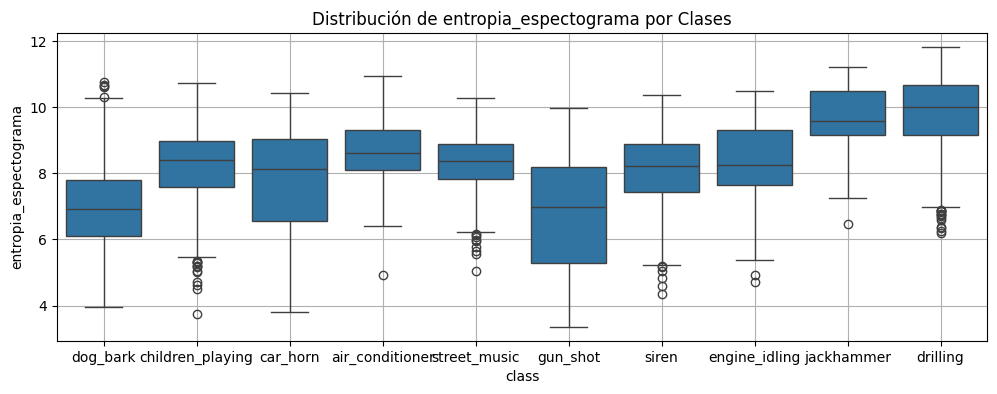

In [21]:
# Distribución de entropia_espectograma por Clases
plt.figure(figsize=(12,4))
ax = sns.boxplot(y=dataset_urbansound8k_df['entropia_espectograma'], x=dataset_urbansound8k_df['class']) 
plt.title("Distribución de entropia_espectograma por Clases")
plt.grid()
plt.show()

### Grafico de onda

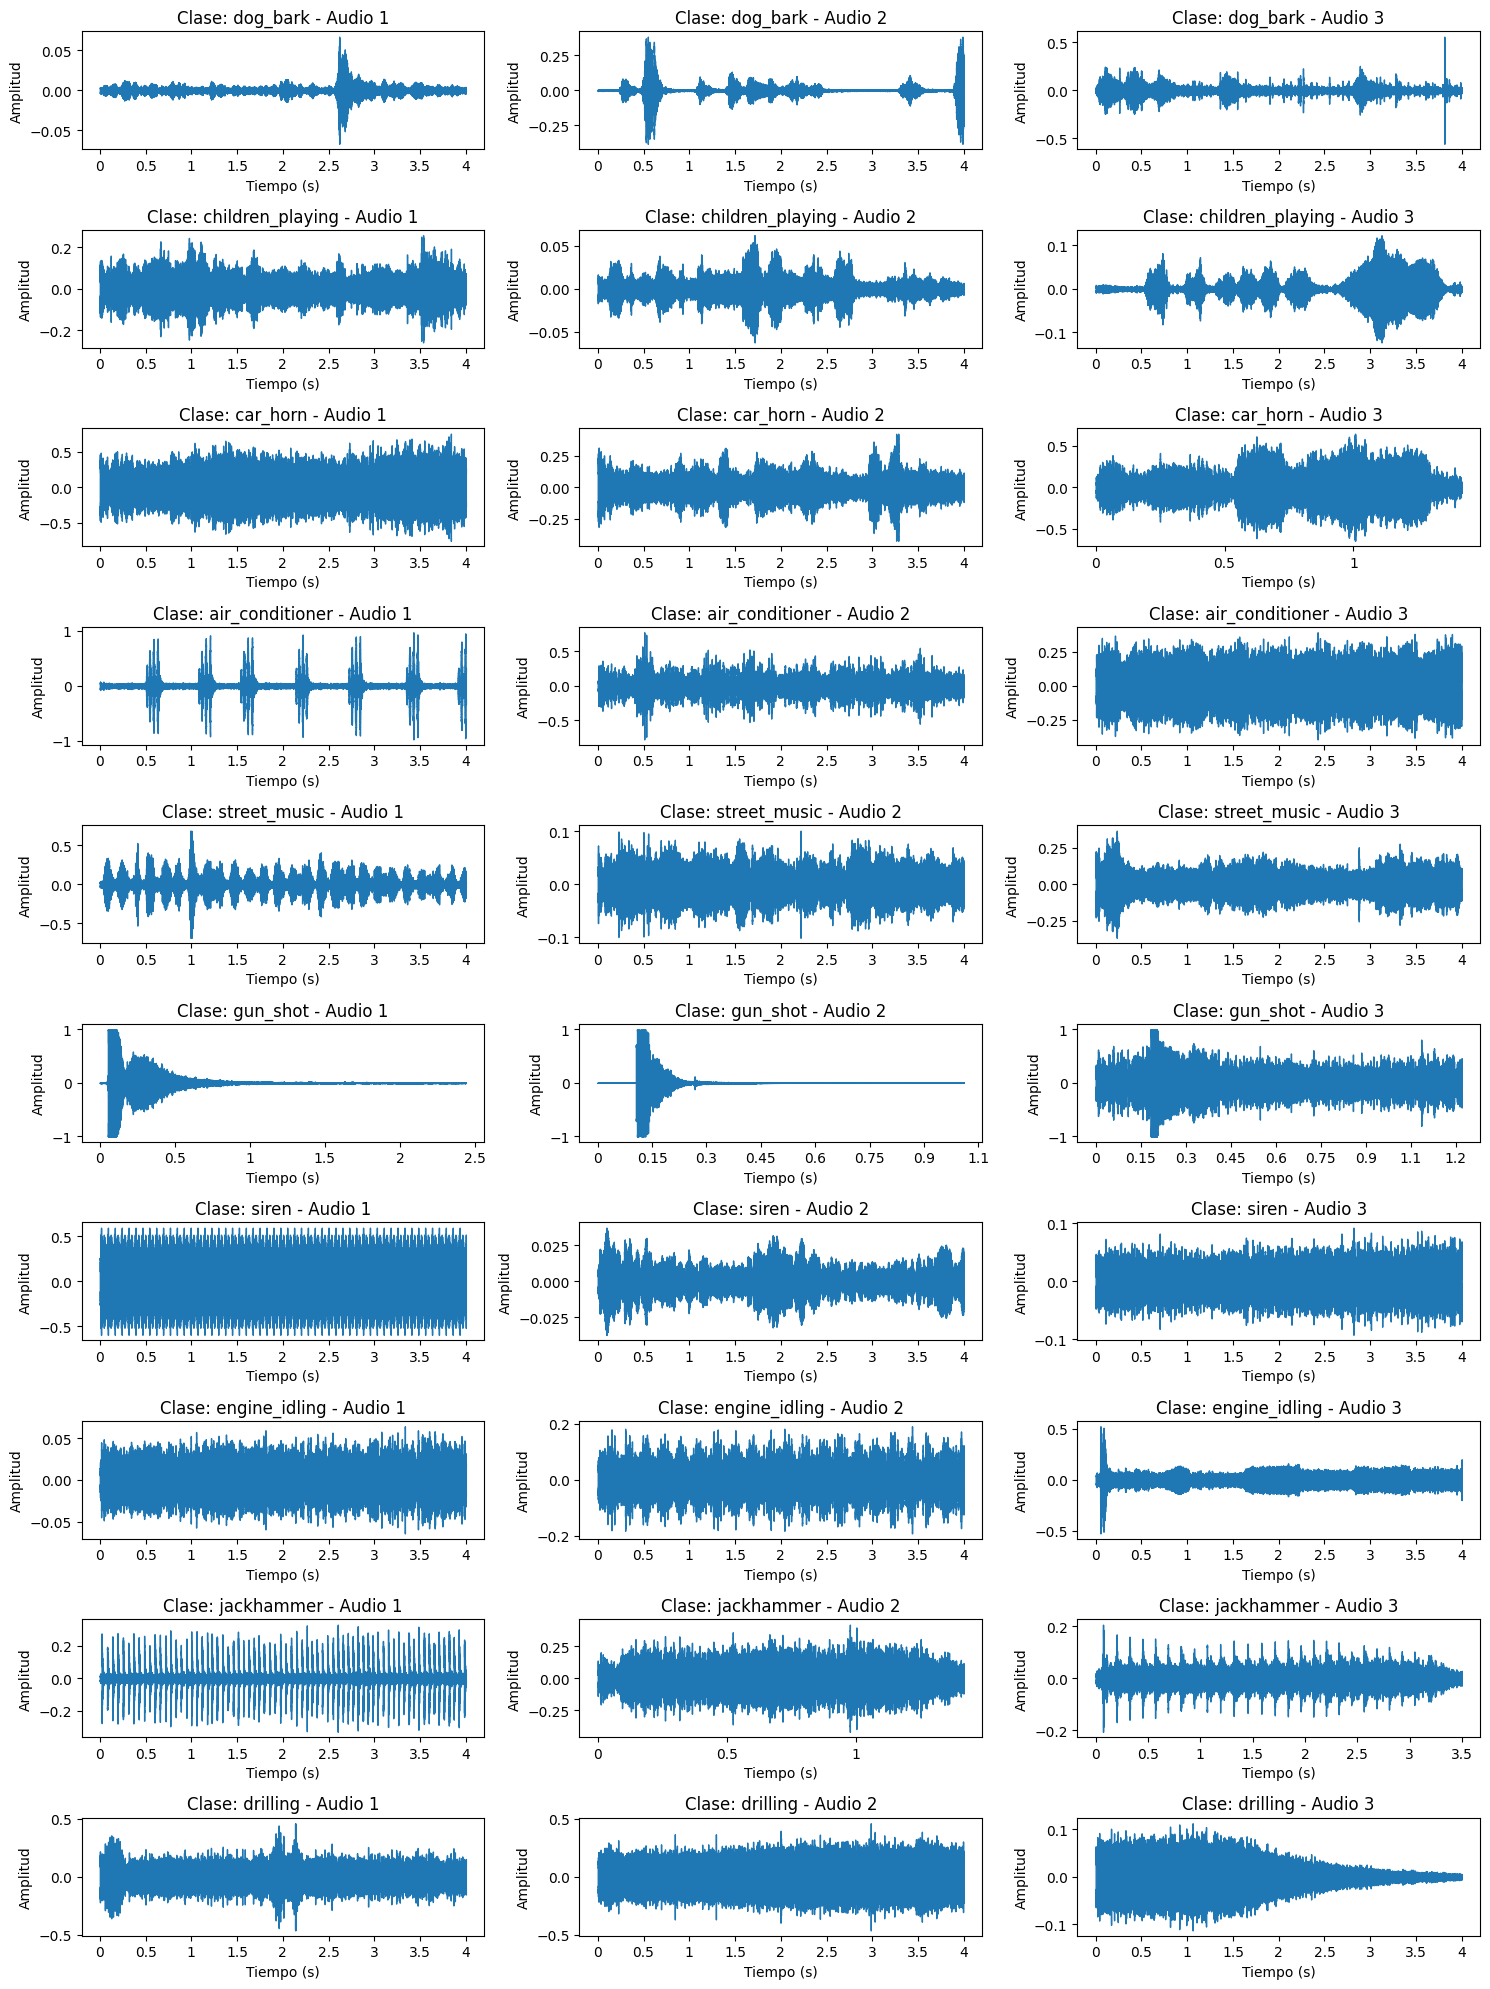

In [22]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd

# Suponiendo que ya tienes un DataFrame llamado `metadata_urbansound8k_df`
# con las columnas 'class' y 'file_path', donde 'file_path' es la ruta del archivo de audio

# Obtener las clases únicas
clases_unicas = dataset_urbansound8k_df['class'].unique()

# Establecer el número de muestras por clase
num_muestras_por_clase = 3

# Crear una figura y ejes para subplots
fig, axes = plt.subplots(nrows=len(clases_unicas), ncols=num_muestras_por_clase, figsize=(15, 20))
fig.tight_layout(pad=3.0)

# Recorrer cada clase
for i, clase in enumerate(clases_unicas):
    # Filtrar el DataFrame para obtener los archivos de la clase actual
    archivos_clase = dataset_urbansound8k_df[dataset_urbansound8k_df['class'] == clase]['path']
    
    # Seleccionar los primeros `num_muestras_por_clase` archivos
    archivos_seleccionados = archivos_clase.sample(n=num_muestras_por_clase, random_state=2)
    
    # Graficar las formas de onda
    for j, archivo in enumerate(archivos_seleccionados):
        signal, sr = librosa.load(archivo, sr=None)  # Cargar el archivo de audio
        
        # Graficar en la subfigura correspondiente
        ax = axes[i, j]
        librosa.display.waveshow(signal, sr=sr, ax=ax)
        ax.set_title(f'Clase: {clase} - Audio {j+1}')
        ax.set_xlabel('Tiempo (s)')
        ax.set_ylabel('Amplitud')

# Ajustar el layout para evitar superposición de títulos
plt.tight_layout()
plt.show()


### Correlacion Variables

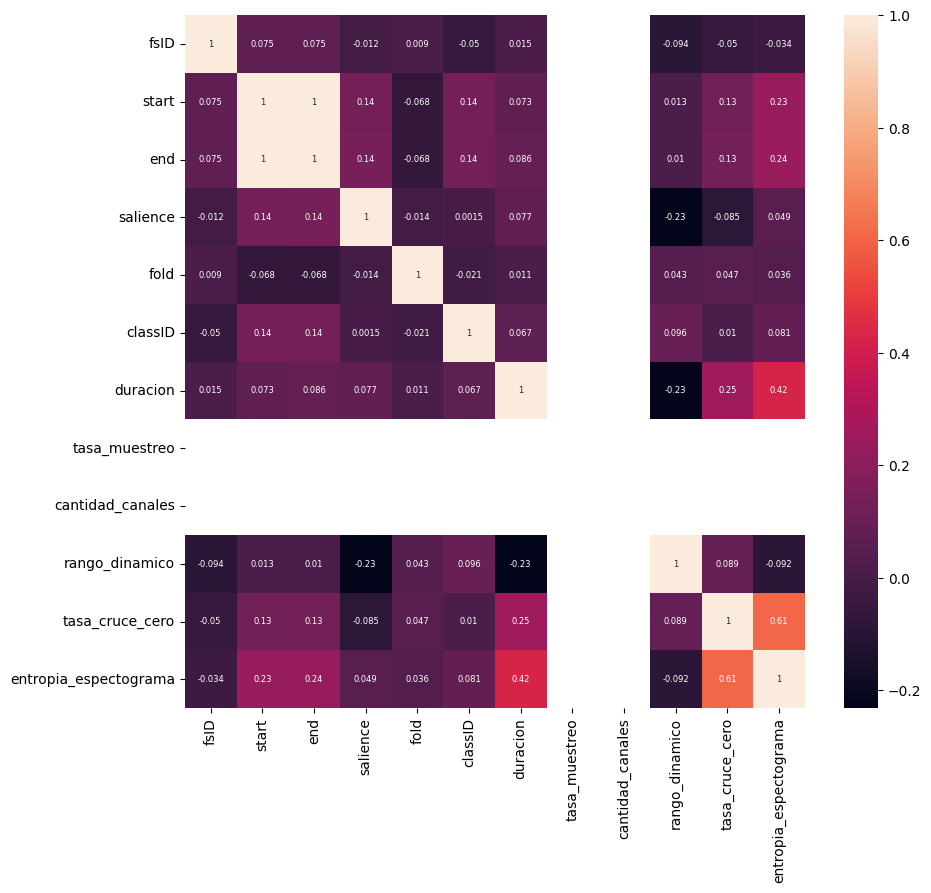

In [23]:
numeric_df = dataset_urbansound8k_df.select_dtypes(include=['float64', 'int64'])
correlacion_result = numeric_df.corr()
plt.figure(figsize=(10, 9))

sj_corr_heat = sns.heatmap(correlacion_result, annot=True, annot_kws={"size": 6})